In [3]:
%pip install pandas numpy tensorflow scikit-learn matplotlib seaborn


Note: you may need to restart the kernel to use updated packages.


In [14]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, Embedding, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, classification_report, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# ---- STEP 1: Load and Prepare Dataset ----
df = pd.read_csv("modifiedDataset.csv")

# Standardize numerical columns
numerical_cols = ["No_of_Attributes", "No_of_Records"]
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Define the visualization class mapping
visualization_classes = {
    1: "Histogram",
    2: "Pie Chart",
    3: "Map",
    4: "Treemap",
    5: "Parallel Coordinates",
    6: "Scatter Plot",
    7: "Linked Graph",
    8: "Line Chart"
}

# Apply the mapping for Chart_Type
df["Chart_Type"] = df["Chart_Type"].map(visualization_classes)

# Define the expertise level mapping
expertise_mapping = {
    0: "Non-Expert",
    1: "Expert"
}

# Apply the mapping for Target Audience
df["Target Audience"] = df["Target Audience"].map(expertise_mapping)


In [15]:
df

,No_of_Attributes,No_of_Records,Primary_Variable (Data Type),Task (Purpose),Target Audience,Chart_Type
0,-0.424763,-0.490825,continous,distribution,Non-Expert,Histogram
1,0.857286,-0.306174,categorical,relationship,Expert,Parallel Coordinates
2,-0.424763,-0.470308,ordinal,trends,Non-Expert,Line Chart
3,-0.424763,-0.506212,continous,distribution,Non-Expert,Histogram
4,-0.424763,-0.505187,continous,distribution,Non-Expert,Histogram
...,...,...,...,...,...,...
395,2.881575,-0.203590,continous,relationship,Expert,Parallel Coordinates
396,0.857286,2.053253,ordinal,comparison,Expert,Treemap
397,-0.424763,-0.475437,ordinal,distribution,Non-Expert,Line Chart
398,-0.424763,-0.465179,continous,distribution,Non-Expert,Histogram


In [16]:
# One-Hot Encoding for categorical features
df = pd.get_dummies(df, columns=['Primary_Variable (Data Type)', 'Task (Purpose)', 'Target Audience'], drop_first=True, dtype=int)

# One-Hot Encoding for target column
encoded_target = pd.get_dummies(df["Chart_Type"], dtype=int)
df = df.drop(columns=["Chart_Type"])

# Assign features (X) and labels (Y)
X = df  # Features include Target Audience (Expert/Non-expert)
Y = encoded_target  # One-hot encoded target visualization class

In [26]:
# ---- STEP 2: K-Fold Cross Validation (10 Folds) ----
kf = KFold(n_splits=10, shuffle=True, random_state=42)
accuracies = []
r2_scores = []
conf_matrix = np.zeros((Y.shape[1], Y.shape[1]))  # Initialize confusion matrix

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

    # ---- STEP 3: Define Neural Network Model ----
    model = Sequential([
        Input(shape=(X_train.shape[1],)),  # Input Layer
        Dense(16, activation='relu'),  # First Hidden Layer
        Dropout(0.2),  # Dropout for Regularization
        Dense(12, activation='relu'),  # Second Hidden Layer
        Dense(Y.shape[1], activation='softmax')  # Output Layer (Softmax for classification)
    ])

    # Compile Model
    optimizer = Adam(learning_rate=0.005)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy', 'mse'])

    # Early Stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # ---- STEP 4: Train Model ----
    history = model.fit(X_train, Y_train, epochs=500, batch_size=10, verbose=1, validation_data=(X_test, Y_test), callbacks=[early_stopping])

    # ---- STEP 5: Evaluate Model ----
    loss, accuracy, mse = model.evaluate(X_test, Y_test)
    accuracies.append(accuracy)

    # ---- STEP 6: Compute Confusion Matrix ----
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(Y_test.values, axis=1)

    fold_conf_matrix = confusion_matrix(y_true_classes, y_pred_classes, labels=range(Y.shape[1]))
    conf_matrix += fold_conf_matrix

    # ---- STEP 7: Compute R² Score ----
    r2 = r2_score(y_true_classes, y_pred_classes)
    r2_scores.append(r2)

# ---- STEP 8: Save the Final Model ----
model.save("visiobot_model.keras")
print("Model saved successfully!")

# Print final accuracy & R²
final_accuracy = np.mean(accuracies) * 100
final_r2 = np.mean(r2_scores)
print(f"Final Mean Accuracy: {final_accuracy:.2f}%")
print(f"Final Mean R² Score: {final_r2:.4f}")


Epoch 1/500


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2624 - loss: 2.0068 - mse: 0.1065 - val_accuracy: 0.4250 - val_loss: 1.6469 - val_mse: 0.0917
Epoch 2/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4223 - loss: 1.5322 - mse: 0.0859 - val_accuracy: 0.5750 - val_loss: 1.1202 - val_mse: 0.0649
Epoch 3/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6312 - loss: 1.0326 - mse: 0.0611 - val_accuracy: 0.8500 - val_loss: 0.7668 - val_mse: 0.0437
Epoch 4/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7634 - loss: 0.8080 - mse: 0.0487 - val_accuracy: 0.8500 - val_loss: 0.5034 - val_mse: 0.0303
Epoch 5/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7829 - loss: 0.6141 - mse: 0.0387 - val_accuracy: 0.9250 - val_loss: 0.3799 - val_mse: 0.0234
Epoch 6/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8950 - loss: 0.4022 - mse: 0.0237 - val_accuracy: 0.9250 - val_loss: 0.3005 - val_mse: 0.0182
Epoch 7/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accur

In [32]:
%pip install ucimlrepo

from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
iris = fetch_ucirepo(id=53) 
  
# data (as pandas dataframes) 
X = iris.data.features 
y = iris.data.targets 
  
# metadata 
print(iris.metadata) 
  
# variable information 
print(iris.variables) 


Note: you may need to restart the kernel to use updated packages.
{'uci_id': 53, 'name': 'Iris', 'repository_url': 'https://archive.ics.uci.edu/dataset/53/iris', 'data_url': 'https://archive.ics.uci.edu/static/public/53/data.csv', 'abstract': 'A small classic dataset from Fisher, 1936. One of the earliest known datasets used for evaluating classification methods.\n', 'area': 'Biology', 'tasks': ['Classification'], 'characteristics': ['Tabular'], 'num_instances': 150, 'num_features': 4, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1936, 'last_updated': 'Tue Sep 12 2023', 'dataset_doi': '10.24432/C56C76', 'creators': ['R. A. Fisher'], 'intro_paper': {'ID': 191, 'type': 'NATIVE', 'title': 'The Iris data set: In search of the source of virginica', 'authors': 'A. Unwin, K. Kleinman', 'venue': 'Significance, 2021', 'year': 2021, 'journal': 'Significance, 2021',

In [ ]:
# Combine features and targets into a single DataFrame
iris_df = pd.concat([X, y], axis=1)

# Define the path where you want to save the file
save_path = "visiobot-backend/uploads/iris.csv"  

# Save as CSV
iris_df.to_csv(save_path, index=False)

print(f"Dataset saved successfully at: {save_path}")

Dataset saved successfully at: visiobot-backend/uploads/iris.csv


: 

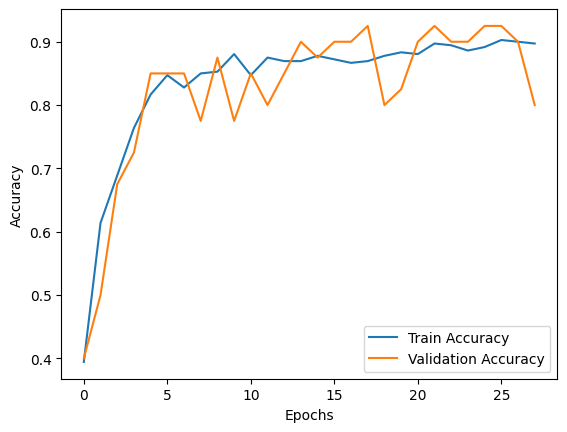

In [27]:
# ---- STEP 9: Plot Accuracy & Loss ----
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

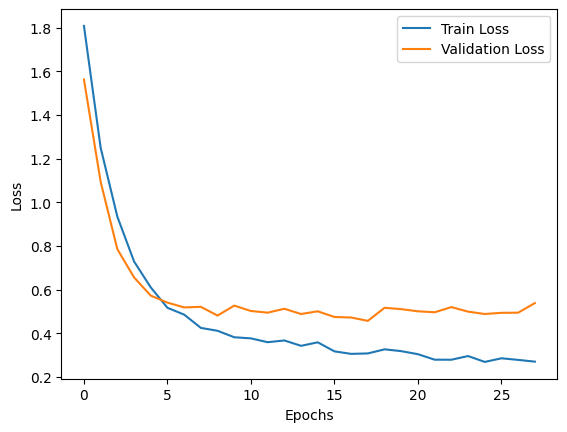

In [28]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

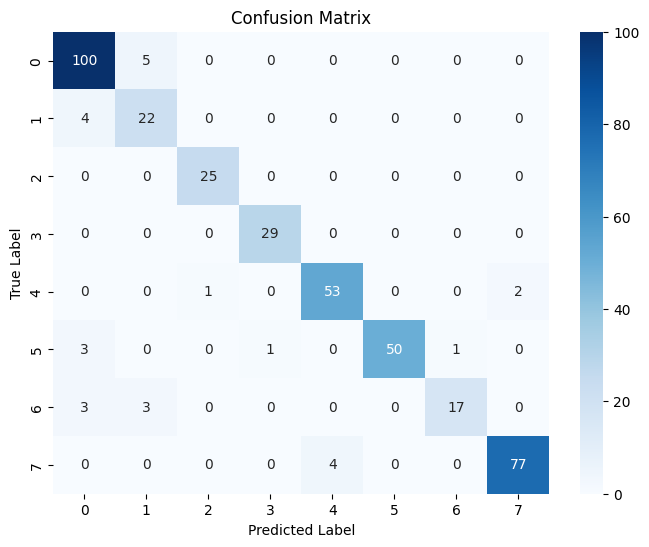

In [29]:
# ---- STEP 10: Display Confusion Matrix ----
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix.astype(int), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [30]:
# ---- STEP 11: Print Classification Report ----
report = classification_report(y_true_classes, y_pred_classes, target_names=list(visualization_classes.values()), labels=range(8))
print("Classification Report:\n", report)

Classification Report:
                       precision    recall  f1-score   support

           Histogram       0.92      1.00      0.96        11
           Pie Chart       0.80      1.00      0.89         4
                 Map       0.00      0.00      0.00         0
             Treemap       1.00      1.00      1.00         3
Parallel Coordinates       1.00      1.00      1.00         5
        Scatter Plot       1.00      0.88      0.93         8
        Linked Graph       0.80      0.67      0.73         6
          Line Chart       1.00      1.00      1.00         3

            accuracy                           0.93        40
           macro avg       0.81      0.82      0.81        40
        weighted avg       0.93      0.93      0.92        40



/usr/local/python/3.11.9/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/python/3.11.9/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/python/3.11.9/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/loc

In [22]:
# ---- STEP 11: Compute Final Metrics ----
TP = np.diag(conf_matrix)
FP = np.sum(conf_matrix, axis=0) - TP
FN = np.sum(conf_matrix, axis=1) - TP
TN = np.sum(conf_matrix) - (TP + FP + FN)

TPR = np.sum(TP) / (np.sum(TP) + np.sum(FN))  # Sensitivity / Recall
TNR = np.sum(TN) / (np.sum(TN) + np.sum(FP))  # Specificity
FPR = np.sum(FP) / (np.sum(FP) + np.sum(TN))  # False Positive Rate
FNR = np.sum(FN) / (np.sum(FN) + np.sum(TP))  # False Negative Rate

print(f"True Positive Rate (TPR / Sensitivity): {TPR:.4f}")
print(f"True Negative Rate (TNR / Specificity): {TNR:.4f}")
print(f"False Positive Rate (FPR): {FPR:.4f}")
print(f"False Negative Rate (FNR): {FNR:.4f}")

True Positive Rate (TPR / Sensitivity): 0.9350
True Negative Rate (TNR / Specificity): 0.9907
False Positive Rate (FPR): 0.0093
False Negative Rate (FNR): 0.0650
